In [1]:
! pip install trulens
import requests

     ---------------------------------------- 84.3/84.3 kB 4.9 MB/s eta 0:00:00


In [71]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from trulens.nn.models import get_model_wrapper
#from torchvision import datasets, transforms, models
import torch
from torch import nn
 import os
import keras
import numpy as np
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

In [65]:
# Function to convert image tensor back to numpy
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

#Directory definitions

train_directory = r'../data/imgs/train'
test_directory = r'../data/imgs/test'
main_directory = r'../data'
device = torch.device("cuda:0")

In [63]:
# Defining the model
model = models.vgg16(pretrained=True)
# Freezing the feature parameters
for param in model.features.parameters():
  param.requires_grad = False

# Defining the loss, optimizer and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# changing the last layer of VGG16 to have a size of 10
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 10)
model.classifier[6] = last_layer
model.to(device)
# load previously saved weights
model.load_state_dict(torch.load(os.path.join(main_directory, '20220529_153619_weights.h5')))
# defining the softmax for converting the output to probabilities
module_softmax = nn.Softmax(dim=1)
print(model) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [74]:
keras_model = VGG16(weights='imagenet')
keras_model.summary() 

# Produce a wrapped model from the keras model.
model = get_model_wrapper(keras_model)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

INFO: Detected tensorflow backend for <class 'keras.engine.functional.Functional'>.
INFO: Using backend Backend.TENSORFLOW.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.


1/1 [==============================] - 0s 179ms/step


[[('n04162706', 'seat_belt', 0.6253269),
  ('n03868863', 'oxygen_mask', 0.21172044),
  ('n03770679', 'minivan', 0.051731408),
  ('n03670208', 'limousine', 0.03245962),
  ('n03814639', 'neck_brace', 0.015498242)]]

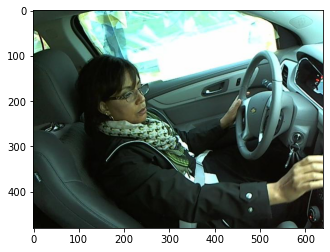

In [96]:
# Load the example record.
# Note that this path assumes this notebook is being run from the root trulens
# directory.
train_directory = r'../data/imgs/test/img_1.jpg'
url = 'https://raw.githubusercontent.com/truera/trulens/master/notebooks/resources/dog_bike.jpg'
with PIL.Image.open(train_directory) as img:
    # View the image.
    plt.imshow(img)
    
    x = np.array(img.resize((224,224), PIL.Image.ANTIALIAS))[np.newaxis]
    
    # Save a pre-processed version for the network's consumption.
    x_pp = preprocess_input(np.array(x, copy=True))

# Pretty-print the model's top 5 predictions on this record.
# output = model(img)
# _, pred = torch.max(output, 1)
# out_soft = module_softmax(output)
decode_predictions(keras_model.predict(x_pp))

In [97]:
from trulens.nn.attribution import InputAttribution
from trulens.nn.attribution import IntegratedGradients

In [98]:
infl = InputAttribution(model)
attrs_input = infl.attributions(x_pp)

In [99]:
from trulens.visualizations import MaskVisualizer

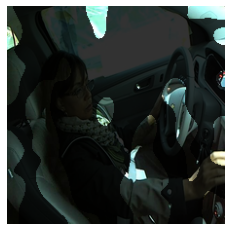

In [115]:
masked_image = MaskVisualizer(blur=10, threshold=0.70)(attrs_input, x)

In [101]:
infl = IntegratedGradients(model, resolution=10)
attrs_input = infl.attributions(x_pp)

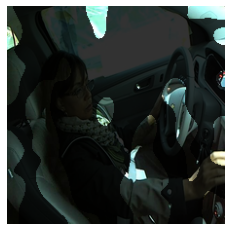

In [114]:
masked_image = MaskVisualizer(blur=10, threshold=0.70)(attrs_input, x)

In [103]:
from trulens.nn.attribution import InternalInfluence
from trulens.nn.distributions import PointDoi
from trulens.nn.quantities import ClassQoI, InternalChannelQoI, MaxClassQoI
from trulens.nn.slices import Cut, InputCut, OutputCut, Slice

In [104]:
# Define the influence measure.
infl = InternalInfluence(
    model, 
    Slice(Cut(-10), OutputCut()), 
    MaxClassQoI(),
    PointDoi())

# Get the attributions for the internal neurons at layer -10. Because layer -10
# contains 2D feature maps, we take the sum over the width and height of the 
# feature maps to obtain a single attribution for each feature map.
attrs_internal = infl.attributions(x_pp).sum(axis=(1,2))

In [105]:
# Define the influence measure.
infl = InternalInfluence(model, -10, 'max', 'point')

# Get the attributions for the internal neurons at layer -10. Because layer -10
# contains 2D feature maps, we take the sum over the width and height of the 
# feature maps to obtain a single attribution for each feature map.
attrs_internal = infl.attributions(x_pp).sum(axis=(1,2))

In [106]:
top_feature_map = int(attrs_internal[0].argmax())

print('Top feature map:', top_feature_map)

Top feature map: 307


In [107]:
  from trulens.visualizations import MaskVisualizer

In [108]:
infl_input = InternalInfluence(
    model, 
    (InputCut(), Cut(-10)),
    InternalChannelQoI(top_feature_map), 
    PointDoi())

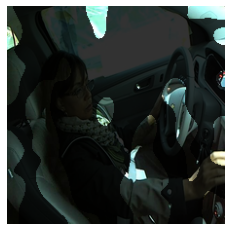

In [116]:
attrs_input = infl_input.attributions(x_pp)

masked_image = MaskVisualizer(blur=10, threshold=0.70)(attrs_input, x)

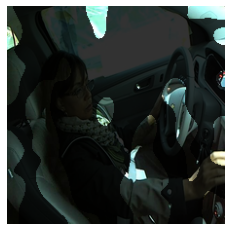

In [117]:
from trulens.visualizations import ChannelMaskVisualizer

masked_image = ChannelMaskVisualizer(
    model,
    -10,
    top_feature_map,
    blur=10, 
    threshold=0.70)(x, x_pp)
plt.axis('off')
plt.imshow(masked_image[0])

Top feature map: 469


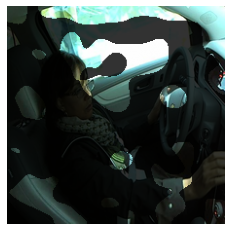

In [118]:
# Define the influence measure.
infl_bike = InternalInfluence(model, -10, 249, 'point')

# The above is shorthand for
#
# infl_bike = InternalInfluence(
#     model, 
#     Slice(Cut(-10), OutputCut()),
#     ClassQoI(249), 
#     'point')

# Get the attributions for each feature map.
attrs_bike_internal = infl_bike.attributions(x_pp).sum(axis=(1,2))

# Find the index of the top feature map.
top_feature_map_bike = int(attrs_bike_internal[0].argmax())

print('Top feature map:', top_feature_map_bike)

# Visualize the top feature map in the input space.
masked_image = ChannelMaskVisualizer(
    model,
    -10,
    top_feature_map_bike,
    blur=10, 
    threshold=0.70)(x, x_pp)
plt.axis('off')
plt.imshow(masked_image[0])